In [3]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 13.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 56.6 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.0/331.0 kB 12.8 MB/s eta 0:00:00


In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
# Load the dataset
file_path = "Synthetic_Data_For_Students.csv"
df = pd.read_csv(file_path)

In [18]:
# Display/Inspect basic info
print("First few rows:")
print(df.head())

print("\nColumn names:")
print(df.columns)

print("\nMissing values:")
print(df.isnull().sum())

First few rows:
   SettlementValue                             AccidentType Injury_Prognosis  \
0            520.0                                 Rear end      E. 5 months   
1            870.0                                 Rear end      B. 2 months   
2           2140.0       Other side pulled out of side road      G. 7 months   
3            520.0  Rear end - Clt pushed into next vehicle      D. 4 months   
4            260.0                                 Rear end      C. 3 months   

   SpecialHealthExpenses  SpecialReduction  SpecialOverage  GeneralRest  \
0                    0.0               0.0             0.0          0.0   
1                    0.0               0.0             0.0        520.0   
2                    0.0               0.0             0.0       1400.0   
3                    0.0               0.0             0.0          0.0   
4                    0.0               0.0             0.0          0.0   

   SpecialAdditionalInjury  SpecialEarningsLoss  Spe

In [19]:
# Before filling missing features drop missing target feature rows
df = df.dropna(subset=['SettlementValue'])

In [20]:
# Handle Missing Values

# Fill numerical missing values with median
num_cols = df.select_dtypes(include=['number']).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Fill categorical missing values with mode
cat_cols = df.select_dtypes(include=['object']).columns
df[cat_cols] = df[cat_cols].apply(lambda x: x.fillna(x.mode()[0]))

print("\nMissing values after handling:")
print(df.isnull().sum())


Missing values after handling:
SettlementValue               0
AccidentType                  0
Injury_Prognosis              0
SpecialHealthExpenses         0
SpecialReduction              0
SpecialOverage                0
GeneralRest                   0
SpecialAdditionalInjury       0
SpecialEarningsLoss           0
SpecialUsageLoss              0
SpecialMedications            0
SpecialAssetDamage            0
SpecialRehabilitation         0
SpecialFixes                  0
GeneralFixed                  0
GeneralUplift                 0
SpecialLoanerVehicle          0
SpecialTripCosts              0
SpecialJourneyExpenses        0
SpecialTherapy                0
Exceptional_Circumstances     0
Minor_Psychological_Injury    0
Dominant injury               0
Whiplash                      0
Vehicle Type                  0
Weather Conditions            0
Accident Date                 0
Claim Date                    0
Vehicle Age                   0
Driver Age                    0
Number o

Create 'Days_To_Claim' column to help capture a useful time-based signal.

In [21]:
# Process Date Features
# If the dataset contains date columns (e.g., Accident Date, Claim Date), extract useful features:

# Clean up column names by stripping extra spaces
df.columns = df.columns.str.strip()

# Convert to datetime
df['Accident Date'] = pd.to_datetime(df['Accident Date'], errors='coerce')
df['Claim Date'] = pd.to_datetime(df['Claim Date'], errors='coerce')

# Create feature: Days between accident and claim
df['Days_To_Claim'] = (df['Claim Date'] - df['Accident Date']).dt.days

# Debugging: Check columns before attempting to drop
print("\nColumns before dropping:")
print(df.columns)

# Drop original date columns if they exist
if 'Accident Date' in df.columns and 'Claim Date' in df.columns:
    df = df.drop(columns=['Accident Date', 'Claim Date'])
    print("\nColumns after dropping:")
    print(df.columns)
else:
    print("Columns to drop not found.")
    
# Debugging: Check column existence again
if 'Accident Date' in df.columns and 'Claim Date' in df.columns:
    print("\nIn Dataset.")
else:
    print("\nNot In Dataset.")


Columns before dropping:
Index(['SettlementValue', 'AccidentType', 'Injury_Prognosis',
       'SpecialHealthExpenses', 'SpecialReduction', 'SpecialOverage',
       'GeneralRest', 'SpecialAdditionalInjury', 'SpecialEarningsLoss',
       'SpecialUsageLoss', 'SpecialMedications', 'SpecialAssetDamage',
       'SpecialRehabilitation', 'SpecialFixes', 'GeneralFixed',
       'GeneralUplift', 'SpecialLoanerVehicle', 'SpecialTripCosts',
       'SpecialJourneyExpenses', 'SpecialTherapy', 'Exceptional_Circumstances',
       'Minor_Psychological_Injury', 'Dominant injury', 'Whiplash',
       'Vehicle Type', 'Weather Conditions', 'Accident Date', 'Claim Date',
       'Vehicle Age', 'Driver Age', 'Number of Passengers',
       'Accident Description', 'Injury Description', 'Police Report Filed',
       'Witness Present', 'Gender', 'Days_To_Claim'],
      dtype='object')

Columns after dropping:
Index(['SettlementValue', 'AccidentType', 'Injury_Prognosis',
       'SpecialHealthExpenses', 'SpecialRedu

In [22]:
# Ecode Categorical Variables (to convert text labels into numbers)

from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for col in cat_cols:
    if col in df.columns:  # Ensure the column still exists
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le
    else:
        print(f"Column '{col}' not found in the DataFrame.")
        print("Categorical columns:", cat_cols)

Column 'Accident Date' not found in the DataFrame.
Categorical columns: Index(['AccidentType', 'Injury_Prognosis', 'Exceptional_Circumstances',
       'Minor_Psychological_Injury', 'Dominant injury', 'Whiplash',
       'Vehicle Type', 'Weather Conditions', 'Accident Date', 'Claim Date',
       'Accident Description', 'Injury Description', 'Police Report Filed',
       'Witness Present', 'Gender'],
      dtype='object')
Column 'Claim Date' not found in the DataFrame.
Categorical columns: Index(['AccidentType', 'Injury_Prognosis', 'Exceptional_Circumstances',
       'Minor_Psychological_Injury', 'Dominant injury', 'Whiplash',
       'Vehicle Type', 'Weather Conditions', 'Accident Date', 'Claim Date',
       'Accident Description', 'Injury Description', 'Police Report Filed',
       'Witness Present', 'Gender'],
      dtype='object')


In [23]:
# Split Data into Train/Test Sets

from sklearn.model_selection import train_test_split

In [24]:
# Separate features and target variable
X = df.drop(columns=['SettlementValue'])  # Replace with correct target column name
y = df['SettlementValue']

In [25]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\nTraining data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)


Training data shape: (3915, 34)
Testing data shape: (979, 34)


In [26]:
# Train a Gradient Boosting Model

# (Pick one algorithm (e.g., CatBoost))
# Train the model
model = CatBoostRegressor(iterations=500, depth=6, learning_rate=0.1, loss_function='RMSE', verbose=100)
model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50)

0:	learn: 811.6280157	test: 825.6819438	best: 825.6819438 (0)	total: 2ms	remaining: 999ms
100:	learn: 287.3451756	test: 295.7237629	best: 295.7237629 (100)	total: 116ms	remaining: 458ms
200:	learn: 238.8452922	test: 267.0084514	best: 267.0084514 (200)	total: 228ms	remaining: 339ms
300:	learn: 203.5165528	test: 249.0689640	best: 249.0519579 (299)	total: 339ms	remaining: 224ms
400:	learn: 178.9972973	test: 240.4204234	best: 240.1586767 (397)	total: 448ms	remaining: 111ms
499:	learn: 157.1754048	test: 232.8054007	best: 232.8008821 (498)	total: 558ms	remaining: 0us

bestTest = 232.8008821
bestIteration = 498

Shrink model to first 499 iterations.


In [27]:
# Make predictions
y_pred = model.predict(X_test)

In [30]:
# Evaluate the model: RMSE, MAE, and R²
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

# Calculate R2 (Coefficient of Determination)
ss_total = np.sum((y_test - np.mean(y_test))**2)  # Total sum of squares
ss_residual = np.sum((y_test - y_pred)**2)  # Residual sum of squares
r2 = 1 - (ss_residual / ss_total)

# Calculate and print the statistics for 'SettlementValue'
print("SettlementValue Summary:")
print("Average SettlementValue:", df['SettlementValue'].mean())
print("Minimum SettlementValue:", df['SettlementValue'].min())
print("Maximum SettlementValue:", df['SettlementValue'].max())
print("Standard Deviation of SettlementValue:", df['SettlementValue'].std())

print("Relative RMSE (% of mean SettlementValue):", (rmse / df['SettlementValue'].mean()) * 100)

# Print the model evaluation results
print(f"\nModel Evaluation:")
print(f"RMSE (how far off predictions are on average): {rmse:.2f}")
print(f"MAE (on average, how much the model is off by (absolute error)): {mae:.2f}")
print(f"R² (how well your model explains the variation in the target variable. A higher value (closer to 1) is better.): {r2:.4f}")

SettlementValue Summary:
Average SettlementValue: 1218.010684511647
Minimum SettlementValue: 240.0
Maximum SettlementValue: 7862.9
Standard Deviation of SettlementValue: 858.8663089786338
Relative RMSE (% of mean SettlementValue): 19.11320529658481

Model Evaluation:
RMSE (how far off predictions are on average): 232.80
MAE (on average, how much the model is off by (absolute error)): 139.66
R² (how well your model explains the variation in the target variable. A higher value (closer to 1) is better.): 0.9283


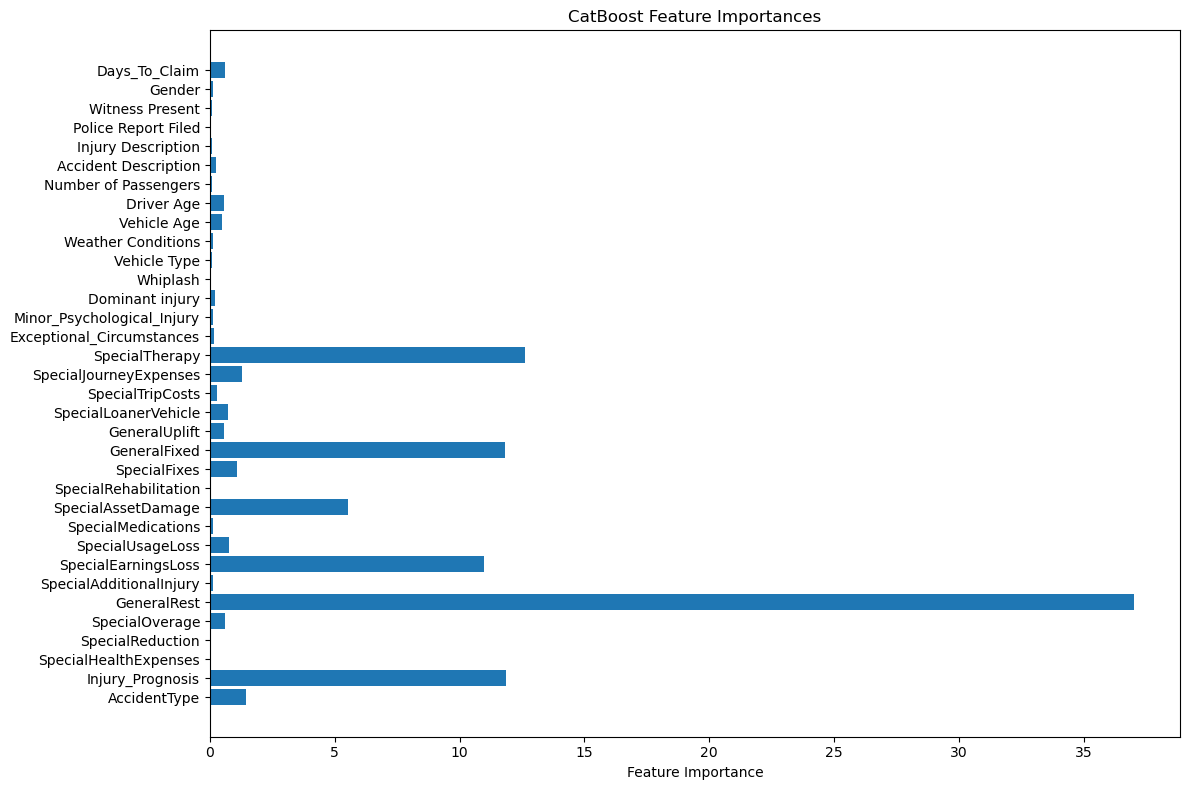

In [31]:
# Plot Feature Importances
feature_importances = model.get_feature_importance()
feature_names = X.columns

plt.figure(figsize=(12, 8))
plt.barh(feature_names, feature_importances)
plt.xlabel("Feature Importance")
plt.title("CatBoost Feature Importances")
plt.tight_layout()
plt.show()

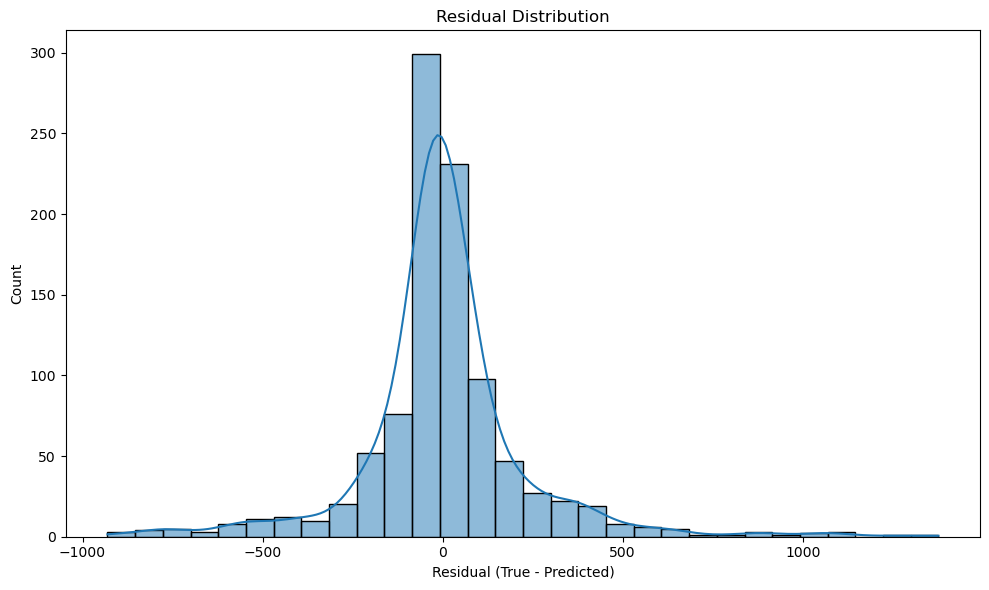

In [32]:
# Plot Residuals
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=30, kde=True)
plt.title("Residual Distribution")
plt.xlabel("Residual (True - Predicted)")
plt.tight_layout()
plt.show()


📊 Model WITH GeneralRest:
  RMSE: 232.80
  R²: 0.9283

📊 Model WITHOUT GeneralRest:
  RMSE: 441.59
  R²: 0.7420


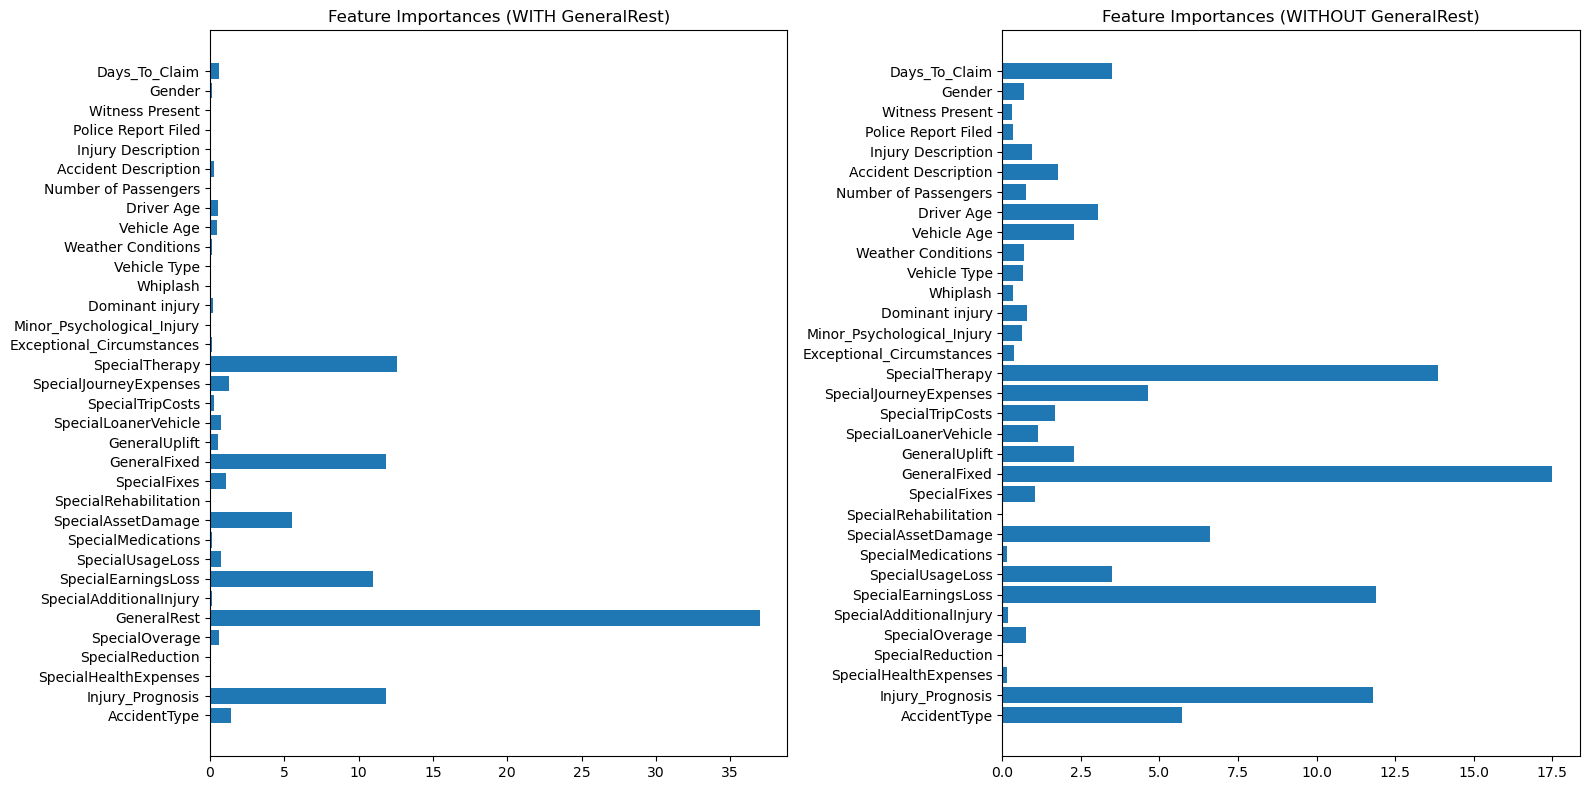

In [33]:
# ---------------------------------
# GeneralRest Feature Side-by-Side Model Comparison
# ---------------------------------

# Create full feature set
X_full = df.drop(columns=['SettlementValue'])
y = df['SettlementValue']

# Create reduced feature set (without GeneralRest)
X_reduced = X_full.drop(columns=['GeneralRest']) if 'GeneralRest' in X_full.columns else X_full.copy()

# Split both datasets
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full, y, test_size=0.2, random_state=42)
X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

# Train Model 1: With GeneralRest
model_full = CatBoostRegressor(iterations=500, depth=6, learning_rate=0.1, loss_function='RMSE', verbose=0)
model_full.fit(X_train_full, y_train_full, eval_set=(X_test_full, y_test_full), early_stopping_rounds=50)

# Train Model 2: Without GeneralRest
model_reduced = CatBoostRegressor(iterations=500, depth=6, learning_rate=0.1, loss_function='RMSE', verbose=0)
model_reduced.fit(X_train_reduced, y_train_reduced, eval_set=(X_test_reduced, y_test_reduced), early_stopping_rounds=50)

# Evaluate both models
def evaluate(model, X_test, y_test, label):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = model.score(X_test, y_test)
    print(f"\n📊 {label}:")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R²: {r2:.4f}")
    return rmse, r2

rmse_full, r2_full = evaluate(model_full, X_test_full, y_test_full, "Model WITH GeneralRest")
rmse_reduced, r2_reduced = evaluate(model_reduced, X_test_reduced, y_test_reduced, "Model WITHOUT GeneralRest")

# Plot Feature Importances
importances_full = model_full.get_feature_importance()
importances_reduced = model_reduced.get_feature_importance()

features_full = X_full.columns
features_reduced = X_reduced.columns

fig, axs = plt.subplots(1, 2, figsize=(16, 8))

axs[0].barh(features_full, importances_full)
axs[0].set_title("Feature Importances (WITH GeneralRest)")

axs[1].barh(features_reduced, importances_reduced)
axs[1].set_title("Feature Importances (WITHOUT GeneralRest)")

plt.tight_layout()
plt.show()

RMSE got a lot worse (jumped from ~377 ➔ ~519).
R2 dropped significantly (from 81.5% ➔ 65.0%).
Based on these results, GeneralRest is critical for the model and should not be dropped.
It is genuinely helping the model make better predictions — not just "taking credit" falsely.

In [36]:
# ---------------------------------
# GridSearch Results
# ---------------------------------

# Define the model
model = CatBoostRegressor(loss_function='RMSE', verbose=0)

# Define the parameter grid to search over
param_grid = {
    'iterations': [100, 200, 300],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5]
}

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Print best parameters from the grid search
print("Best parameters found: ", grid_search.best_params_)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions using the best model
y_pred = best_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

# Calculate R2 (Coefficient of Determination)
ss_total = np.sum((y_test - np.mean(y_test))**2)  # Total sum of squares
ss_residual = np.sum((y_test - y_pred)**2)  # Residual sum of squares
r2 = 1 - (ss_residual / ss_total)

# Print the results
print(f"\nModel Evaluation:")
print(f"RMSE (how far off predictions are on average): {rmse:.2f}")
print(f"MAE (on average, how much the model is off by (absolute error)): {mae:.2f}")
print(f"R² (how well your model explains the variation in the target variable. A higher value (closer to 1) is better.): {r2:.4f}")

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best parameters found:  {'depth': 6, 'iterations': 300, 'l2_leaf_reg': 1, 'learning_rate': 0.1}

Model Evaluation:
RMSE (how far off predictions are on average): 234.87
MAE (on average, how much the model is off by (absolute error)): 140.21
R² (how well your model explains the variation in the target variable. A higher value (closer to 1) is better.): 0.9270
